In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Perceptrons

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

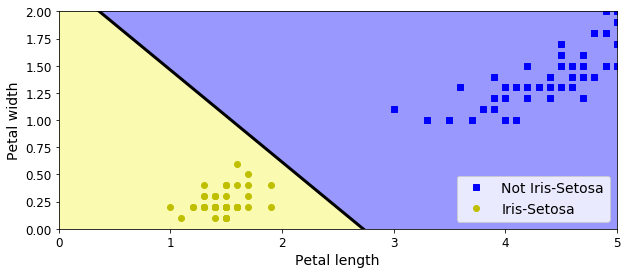

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

#save_fig("perceptron_iris_plot")
plt.show()

# Activation Functions

In [5]:
def logit(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

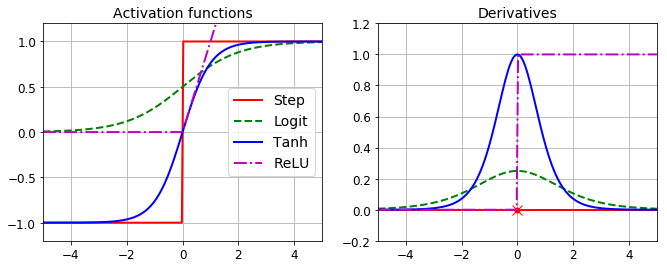

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, logit(z), "g--", linewidth=2, label="Logit")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(logit, z), "g--", linewidth=2, label="Logit")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("activation_functions_plot")
plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

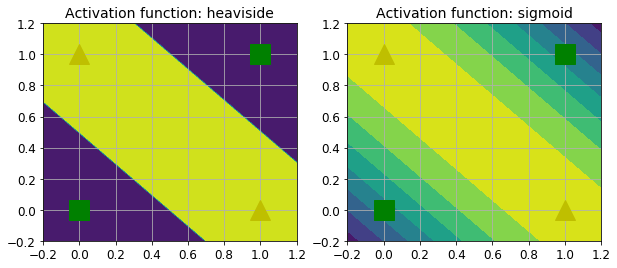

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# DNN

In [9]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [10]:
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

In [11]:
import tensorflow as tf

config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300, 100], n_classes=10, feature_columns=feature_columns)
dnn_clf.fit(x=X_train, y=y_train, batch_size=50, steps=40000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_evaluation_master': '', '_environment': 'local', '_model_dir': 'C:\\Users\\WNA\\AppData\\Local\\Temp\\tmp5ae83h7l', '_num_worker_replicas': 0, '_master': '', '_is_chief': True, '_tf_random_seed': None, '_task_id': 0, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000011B55780>, '_session_config': None, '_task_type': None, '_num_ps_replicas': 0}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions

INFO:tensorflow:global_step/sec: 323.606
INFO:tensorflow:loss = 0.0352572, step = 5301 (0.309 sec)
INFO:tensorflow:global_step/sec: 327.85
INFO:tensorflow:loss = 0.0724296, step = 5401 (0.306 sec)
INFO:tensorflow:global_step/sec: 322.562
INFO:tensorflow:loss = 0.0427374, step = 5501 (0.309 sec)
INFO:tensorflow:global_step/sec: 325.714
INFO:tensorflow:loss = 0.0746058, step = 5601 (0.307 sec)
INFO:tensorflow:global_step/sec: 323.606
INFO:tensorflow:loss = 0.0149973, step = 5701 (0.309 sec)
INFO:tensorflow:global_step/sec: 328.928
INFO:tensorflow:loss = 0.00904106, step = 5801 (0.304 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.0756104, step = 5901 (0.308 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.161301, step = 6001 (0.308 sec)
INFO:tensorflow:global_step/sec: 326.779
INFO:tensorflow:loss = 0.0146014, step = 6101 (0.306 sec)
INFO:tensorflow:global_step/sec: 323.606
INFO:tensorflow:loss = 0.0146497, step = 6201 (0.309 sec)
INFO:tensor

INFO:tensorflow:loss = 0.00766098, step = 13501 (0.310 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.00665922, step = 13601 (0.308 sec)
INFO:tensorflow:global_step/sec: 322.562
INFO:tensorflow:loss = 0.00689551, step = 13701 (0.310 sec)
INFO:tensorflow:global_step/sec: 326.779
INFO:tensorflow:loss = 0.00454976, step = 13801 (0.306 sec)
INFO:tensorflow:global_step/sec: 327.85
INFO:tensorflow:loss = 0.0029091, step = 13901 (0.305 sec)
INFO:tensorflow:global_step/sec: 330.014
INFO:tensorflow:loss = 0.00205268, step = 14001 (0.303 sec)
INFO:tensorflow:global_step/sec: 320.494
INFO:tensorflow:loss = 0.00379633, step = 14101 (0.312 sec)
INFO:tensorflow:global_step/sec: 330.014
INFO:tensorflow:loss = 0.00878454, step = 14201 (0.303 sec)
INFO:tensorflow:global_step/sec: 323.606
INFO:tensorflow:loss = 0.00087628, step = 14301 (0.309 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.000876817, step = 14401 (0.308 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.000762344, step = 21701 (0.308 sec)
INFO:tensorflow:global_step/sec: 328.929
INFO:tensorflow:loss = 0.000601784, step = 21801 (0.305 sec)
INFO:tensorflow:global_step/sec: 321.525
INFO:tensorflow:loss = 0.000263422, step = 21901 (0.310 sec)
INFO:tensorflow:global_step/sec: 322.562
INFO:tensorflow:loss = 5.69055e-05, step = 22001 (0.311 sec)
INFO:tensorflow:global_step/sec: 325.715
INFO:tensorflow:loss = 0.000225381, step = 22101 (0.306 sec)
INFO:tensorflow:global_step/sec: 331.107
INFO:tensorflow:loss = 0.00177529, step = 22201 (0.302 sec)
INFO:tensorflow:global_step/sec: 325.714
INFO:tensorflow:loss = 0.00144527, step = 22301 (0.307 sec)
INFO:tensorflow:global_step/sec: 323.606
INFO:tensorflow:loss = 0.00206663, step = 22401 (0.309 sec)
INFO:tensorflow:global_step/sec: 327.85
INFO:tensorflow:loss = 0.00132188, step = 22501 (0.306 sec)
INFO:tensorflow:global_step/sec: 322.562
INFO:tensorflow:loss = 0.00336933, step = 2260

INFO:tensorflow:global_step/sec: 330.014
INFO:tensorflow:loss = 0.000446448, step = 29801 (0.302 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.00127651, step = 29901 (0.308 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 9.31106e-05, step = 30001 (0.308 sec)
INFO:tensorflow:global_step/sec: 325.714
INFO:tensorflow:loss = 0.000906231, step = 30101 (0.307 sec)
INFO:tensorflow:global_step/sec: 330.014
INFO:tensorflow:loss = 0.000314525, step = 30201 (0.303 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.00115384, step = 30301 (0.308 sec)
INFO:tensorflow:global_step/sec: 327.85
INFO:tensorflow:loss = 0.00172788, step = 30401 (0.305 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.00066133, step = 30501 (0.308 sec)
INFO:tensorflow:global_step/sec: 323.606
INFO:tensorflow:loss = 0.000652549, step = 30601 (0.309 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.000536553, step = 307

INFO:tensorflow:global_step/sec: 318.453
INFO:tensorflow:loss = 0.00182905, step = 37901 (0.308 sec)
INFO:tensorflow:global_step/sec: 331.107
INFO:tensorflow:loss = 0.000372218, step = 38001 (0.303 sec)
INFO:tensorflow:global_step/sec: 327.85
INFO:tensorflow:loss = 0.0009458, step = 38101 (0.304 sec)
INFO:tensorflow:global_step/sec: 322.562
INFO:tensorflow:loss = 0.000555262, step = 38201 (0.310 sec)
INFO:tensorflow:global_step/sec: 326.779
INFO:tensorflow:loss = 7.03446e-05, step = 38301 (0.307 sec)
INFO:tensorflow:global_step/sec: 324.657
INFO:tensorflow:loss = 0.000264446, step = 38401 (0.307 sec)
INFO:tensorflow:global_step/sec: 322.562
INFO:tensorflow:loss = 0.000322443, step = 38501 (0.310 sec)
INFO:tensorflow:global_step/sec: 325.715
INFO:tensorflow:loss = 0.000915823, step = 38601 (0.307 sec)
INFO:tensorflow:global_step/sec: 326.779
INFO:tensorflow:loss = 0.000568603, step = 38701 (0.306 sec)
INFO:tensorflow:global_step/sec: 323.606
INFO:tensorflow:loss = 0.000168028, step = 38

DNNClassifier(params={'feature_columns': (_RealValuedColumn(column_name='', dimension=784, default_value=None, dtype=tf.float32, normalizer=None),), 'activation_fn': <function relu at 0x000000000CF70048>, 'input_layer_min_slice_size': None, 'hidden_units': [300, 100], 'optimizer': None, 'gradient_clip_norm': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x0000000011B553C8>, 'embedding_lr_multipliers': None, 'dropout': None})

In [12]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict_classes(X_test)
accuracy_score(y_test, y_pred['classes'])

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from C:\Users\WNA\AppData\Local\Temp\tmp5ae83h7l\model.ckpt-40000


TypeError: 'generator' object is not subscriptable

In [17]:
from sklearn.metrics import log_loss

y_pred_proba = y_pred['probabilities']
log_loss(y_test, y_pred_proba)

TypeError: 'generator' object is not subscriptable

# Using plane tensorflow

In [13]:
import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [14]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [15]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [16]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [17]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [18]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [19]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [20]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
n_epochs = 40
batch_size = 50

In [22]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
    save_path = saver.save(sess, "./mymodel_final.ckpt")
            

0 Train accuracy: 0.9 Test accuracy: 0.9125
1 Train accuracy: 0.94 Test accuracy: 0.9291
2 Train accuracy: 0.92 Test accuracy: 0.9399
3 Train accuracy: 0.96 Test accuracy: 0.9455
4 Train accuracy: 0.92 Test accuracy: 0.9509
5 Train accuracy: 0.94 Test accuracy: 0.9542
6 Train accuracy: 0.98 Test accuracy: 0.9556
7 Train accuracy: 0.96 Test accuracy: 0.9594
8 Train accuracy: 0.92 Test accuracy: 0.9629
9 Train accuracy: 0.96 Test accuracy: 0.9646
10 Train accuracy: 0.98 Test accuracy: 0.9654
11 Train accuracy: 0.94 Test accuracy: 0.9669
12 Train accuracy: 1.0 Test accuracy: 0.9689
13 Train accuracy: 0.96 Test accuracy: 0.9684
14 Train accuracy: 1.0 Test accuracy: 0.9699
15 Train accuracy: 1.0 Test accuracy: 0.9716
16 Train accuracy: 1.0 Test accuracy: 0.9713
17 Train accuracy: 0.98 Test accuracy: 0.9715
18 Train accuracy: 1.0 Test accuracy: 0.9731
19 Train accuracy: 1.0 Test accuracy: 0.9733
20 Train accuracy: 0.98 Test accuracy: 0.974
21 Train accuracy: 1.0 Test accuracy: 0.974
22 Train

In [26]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./my_model_final.ckpt
	 [[Node: save/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_2/tensor_names, save/RestoreV2_2/shape_and_slices)]]
	 [[Node: save/RestoreV2_4/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_16_save/RestoreV2_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_2', defined at:
  File "c:\users\wna\appdata\local\programs\python\python35\lib\runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-74f077792af3>", line 2, in <module>
    saver = tf.train.Saver()
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\saver.py", line 1139, in __init__
    self.build()
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\saver.py", line 691, in build
    restore_sequentially, reshape)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\training\saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "c:\users\wna\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./my_model_final.ckpt
	 [[Node: save/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_2/tensor_names, save/RestoreV2_2/shape_and_slices)]]
	 [[Node: save/RestoreV2_4/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_16_save/RestoreV2_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


# Using dense()

In [27]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [28]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [29]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [30]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [31]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [32]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [33]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
n_epochs = 20
n_batches = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.88 Test accuracy: 0.9033
1 Train accuracy: 0.9 Test accuracy: 0.9213
2 Train accuracy: 0.94 Test accuracy: 0.9303
3 Train accuracy: 0.92 Test accuracy: 0.9376
4 Train accuracy: 0.92 Test accuracy: 0.9438
5 Train accuracy: 0.94 Test accuracy: 0.9466
6 Train accuracy: 0.92 Test accuracy: 0.9505
7 Train accuracy: 1.0 Test accuracy: 0.9527
8 Train accuracy: 0.96 Test accuracy: 0.9556
9 Train accuracy: 0.94 Test accuracy: 0.9588
10 Train accuracy: 0.92 Test accuracy: 0.9611
11 Train accuracy: 0.96 Test accuracy: 0.9622
12 Train accuracy: 1.0 Test accuracy: 0.9638
13 Train accuracy: 0.96 Test accuracy: 0.9651
14 Train accuracy: 1.0 Test accuracy: 0.9665
15 Train accuracy: 0.92 Test accuracy: 0.9683
16 Train accuracy: 0.92 Test accuracy: 0.9693
17 Train accuracy: 0.98 Test accuracy: 0.9689
18 Train accuracy: 1.0 Test accuracy: 0.9694
19 Train accuracy: 1.0 Test accuracy: 0.9715


In [35]:
show_graph(tf.get_default_graph())

NameError: name 'show_graph' is not defined

In [36]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [37]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [38]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [39]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)

In [40]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [41]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [42]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [45]:
logdir = log_dir("mnist_dnn")

In [46]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [47]:
X_valid = mnist.validation.images
y_valid = mnist.validation.labels

In [48]:
m, n = X_train.shape

In [49]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_deep_mnist_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(accuracy_val * 100),
                  "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break

Epoch: 0 	Validation accuracy: 90.360% 	Loss: 0.35457
Epoch: 5 	Validation accuracy: 95.000% 	Loss: 0.17745
Epoch: 10 	Validation accuracy: 96.640% 	Loss: 0.12656
Epoch: 15 	Validation accuracy: 97.060% 	Loss: 0.10428
Epoch: 20 	Validation accuracy: 97.460% 	Loss: 0.08831
Epoch: 25 	Validation accuracy: 97.760% 	Loss: 0.07972
Epoch: 30 	Validation accuracy: 97.880% 	Loss: 0.07577
Epoch: 35 	Validation accuracy: 98.020% 	Loss: 0.06893
Epoch: 40 	Validation accuracy: 98.060% 	Loss: 0.06785
Epoch: 45 	Validation accuracy: 98.060% 	Loss: 0.06542
Epoch: 50 	Validation accuracy: 98.100% 	Loss: 0.06468
Epoch: 55 	Validation accuracy: 98.120% 	Loss: 0.06465
Epoch: 60 	Validation accuracy: 98.140% 	Loss: 0.06371
Epoch: 65 	Validation accuracy: 98.120% 	Loss: 0.06358
Epoch: 70 	Validation accuracy: 98.140% 	Loss: 0.06501
Epoch: 75 	Validation accuracy: 98.080% 	Loss: 0.06457
Epoch: 80 	Validation accuracy: 98.080% 	Loss: 0.06464
Epoch: 85 	Validation accuracy: 98.120% 	Loss: 0.06432
Epoch: 90 	V